<a href="https://colab.research.google.com/github/adrian-soch/frontier_exploration/blob/as%2Fadd-model/learning_based_frontier_detection/yolov5-custom-training-64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Install Requirements

In [1]:
#clone YOLOv5 and 
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 15368, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 15368 (delta 2), reused 6 (delta 1), pack-reused 15355
Receiving objects: 100% (15368/15368), 14.36 MiB | 21.53 MiB/s, done.
Resolving deltas: 100% (10502/10502), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 KB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 KB 7.2 MB/s eta 0:00:00
Setup complete. Using torch 2.0.0+cu118 (Tesla T4)


In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="O6vsPUJcFqHX0o6PWJ4m")
project = rf.workspace("cas726").project("learned-frontier-detection")
dataset = project.version(2).download("yolov5")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Learned-Frontier-Detection-2 in yolov5pytorch:: 100%|██████████| 150/150 [00:00<00:00, 6431.01it/s]


# Step 3: Train Our Custom YOLOv5 model

Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** Our dataset locaiton is saved in the `dataset.location`
- **weights:** specify a path to weights to start transfer learning from. Here we choose the generic COCO pretrained checkpoint.
- **cache:** cache images for faster training

In [4]:
IMG_SIZE = 64
!python train.py --img {IMG_SIZE} --batch 32 --epochs 333 --data {dataset.location}/data.yaml --weights yolov5n.pt --cache --freeze 10

2023-04-07 17:30:23.689019: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 17:30:24.671924: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=yolov5n.pt, cfg=, data=/content/yolov5/Learned-Frontier-Detection-2/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=333, batch_size=32, imgsz=64, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[10], save_period=-1, seed=0, local_rank=-1, e

# Evaluate Custom YOLOv5 Detector Performance
Training losses and performance metrics are saved to Tensorboard and also to a logfile.

If you are new to these metrics, the one you want to focus on is `mAP_0.5` - learn more about mean average precision [here](https://blog.roboflow.com/mean-average-precision/).

#Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [6]:
!python detect.py --weights runs/train/exp/weights/best.pt --img {IMG_SIZE} --conf 0.5 --source {dataset.location}/test/images --max-det 20 --line-thickness 1

detect: weights=['runs/train/exp/weights/best.pt'], source=/content/yolov5/Learned-Frontier-Detection-2/test/images, data=data/coco128.yaml, imgsz=[64, 64], conf_thres=0.5, iou_thres=0.45, max_det=20, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=1, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-134-g23c4923 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 1760518 parameters, 0 gradients, 4.1 GFLOPs
image 1/4 /content/yolov5/Learned-Frontier-Detection-2/test/images/16_506_957_0-030000_png.rf.a49cbfb0535a240b06245fcc62749fab.jpg: 64x64 2 frontiers, 5.2ms
image 2/4 /content/yolov5/Learned-Frontier-Detection-2/test/images/1_503_821_0-030000_png.rf.0df814ba8c622da16c2d58df940b7b4b.jpg: 64x64 4 frontiers, 6.1ms
ima

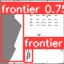

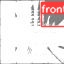

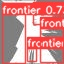

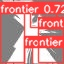

In [9]:
#display inference on ALL test images

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

# Conclusion and Next Steps

Congratulations! You've trained a custom YOLOv5 model to recognize your custom objects.

To improve you model's performance, we recommend first interating on your datasets coverage and quality. See this guide for [model performance improvement](https://github.com/ultralytics/yolov5/wiki/Tips-for-Best-Training-Results).

To deploy your model to an application, see this guide on [exporting your model to deployment destinations](https://github.com/ultralytics/yolov5/issues/251).

Once your model is in production, you will want to continually iterate and improve on your dataset and model via [active learning](https://blog.roboflow.com/what-is-active-learning/).

In [ ]:
#export your model's weights for future use
from google.colab import files
files.download('./runs/train/exp/weights/best.pt')